In [1]:
'''
Author: JYYD jyyd23@mails.tsinghua.edu.cn
Date: 2023-11-29 20:58:00
LastEditors: JYYD jyyd23@mails.tsinghua.edu.cn
LastEditTime: 2023-12-03 21:44:11
FilePath: \PNC\code\finalcode\PNC_estimate\PNC_estimate_plot.ipynb
'''
import pandas as pd
import numpy as np
from scipy.io import loadmat
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns


def find_new_method(col_name, gisdata, lonNew, latNew, avgConc):
    
    lonNew = lonNew.ravel()
    latNew = latNew.ravel()
    
    # define a function to find the nearest index and value of the grid
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx, array[idx]

    def get_surrounding_indices(i, j, shape):
        return [(i-1, j-1), (i-1, j), (i, j-1), (i, j)]
    
    gisdata[col_name] = 0
    for index, row in gisdata.iterrows():
        lon_idx, nearest_lon = find_nearest(lonNew, row['siteLon'])
        lat_idx, nearest_lat = find_nearest(latNew, row['siteLat'])
        
        dist_to_center = np.sqrt((nearest_lat + 0.005 - row['siteLat'])**2 + 
                                 (nearest_lon + 0.005 - row['siteLon'])**2)
        
        dist_to_cross = np.sqrt((nearest_lat - row['siteLat'])**2 + 
                                (nearest_lon - row['siteLon'])**2)

        # near the center
        if dist_to_center < dist_to_cross:
            gisdata.at[index, col_name] = avgConc[lat_idx, lon_idx]
        else:  # near the cross
            surrounding = get_surrounding_indices(lat_idx, lon_idx, avgConc.shape)
            # calculate the mean value of the surrounding 4 grids
            mean_value = np.mean([avgConc[i, j] for i, j in surrounding if 0 <= i < avgConc.shape[0] and 0 <= j < avgConc.shape[1]])
            gisdata.at[index, col_name] = mean_value

    return gisdata

def find_new_method2(col_name, gisdata, lonNew, latNew, avgConc):
    
    lonNew = lonNew.ravel()
    latNew = latNew.ravel()
    
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx, array[idx]

    def get_surrounding_indices(i, j, shape):
        indices = [(i+x, j+y) for x in [-1, 0, 1] for y in [-1, 0, 1]]
        return [(x, y) for x, y in indices if 0 <= x < shape[0] and 0 <= y < shape[1]]
    
    def out_data(pnc_values):
        Q1 = np.percentile(pnc_values, 25)
        Q3 = np.percentile(pnc_values, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = [x for x in pnc_values if x < lower_bound or x > upper_bound]
        return outliers
    
    gisdata[col_name] = None
    values = []
    for index, row in gisdata.iterrows():
        lon_idx, _ = find_nearest(lonNew, row['siteLon'])
        lat_idx, _ = find_nearest(latNew, row['siteLat'])
        
        surrounding = get_surrounding_indices(lat_idx, lon_idx, avgConc.shape)
        values.append([avgConc[i, j] for i, j in surrounding])
        temp = [avgConc[i, j] for i, j in surrounding]
        if row['stn'] == 'HAE':
            return_mean_data = np.max(temp)
        else:
            outliers = out_data(temp)
            for outlier in outliers:
                temp.remove(outlier)
            return_mean_data = np.mean(temp)
        gisdata.at[index, col_name] = return_mean_data

    return gisdata, values

path_0 = os.path.abspath(os.path.join(os.getcwd(),"../.."))
gisdata = pd.read_csv(path_0 + '/pncEstimator-main/data/station_gis.csv')
# the original PNC data
pnc2020data = pd.read_csv(path_0 + '/pncEstimator-main/data/NABEL/feature_eng/feature_data_2020.csv')
pnc2020data = pnc2020data.drop(['Unnamed: 0'], axis=1)
# the predicted PNC data
pnc_pred2020 = pd.read_csv('../../mypred/out/pred_table/pnc_pred/pncdata2020_pred1128.csv')
pnc_pred2020  = pnc_pred2020.drop(['Unnamed: 0'], axis=1)

pnc_values = []
matpnc = os.listdir(path_0 + '/pncEstimator-main/src/postProcessing/matdata/PNCtest/0102/')
for data in matpnc:
    if data.endswith('.mat'):
        print(data)
        matdata = loadmat(path_0 + '/pncEstimator-main/src/postProcessing/matdata/PNCtest/0102/' + data)
        lonNew = matdata['lonNew']
        latNew = matdata['latNew']
        avgConc = matdata['avgConc']
        col_name = data.split('_')[2].split('.')[0] + '_avgConc'
        gisdata, values = find_new_method(col_name, gisdata, lonNew, latNew, avgConc)
        if col_name == 'Stacking_avgConc':
            pnc_values.append(values)

# calculate the mean and std CPC value for each station
avg_cpc_by_station = pnc2020data.groupby('station')['CPC [1/cm3]'].mean().reset_index()
std_cpc_by_station = pnc2020data.groupby('station')['CPC [1/cm3]'].std().reset_index()
avg_cpc_by_station.columns = ['station', 'avg_cpc']
std_cpc_by_station.columns = ['station', 'std_cpc']

# calculate the mean and std pred PNC value for each station
avg_pnc_pred_by_station = pnc_pred2020.groupby('station')['stack_pred'].mean().reset_index()
std_pnc_pred_by_station = pnc_pred2020.groupby('station')['stack_pred'].std().reset_index()
avg_pnc_pred_by_station.columns = ['station', 'avg_pnc_pred']
std_pnc_pred_by_station.columns = ['station', 'std_pnc_pred']

# merge the CPC value with the gis data
merged_df = pd.merge(avg_cpc_by_station, gisdata, left_on='station', right_on='stn', how='inner')
merged_df = pd.merge(std_cpc_by_station, merged_df, left_on='station', right_on='stn', how='inner')
# merge the pred PNC value with the gis data
merged_df = pd.merge(avg_pnc_pred_by_station, merged_df, left_on='station', right_on='stn', how='inner')
merged_df = pd.merge(std_pnc_pred_by_station, merged_df, left_on='station', right_on='stn', how='inner')
print(merged_df.columns)

2020PNC_avgConc_Stacking.mat
Index(['station', 'std_pnc_pred', 'station_x', 'avg_pnc_pred', 'station_y',
       'std_cpc', 'station_x', 'avg_cpc', 'stn', 'station simple', 'station2',
       'station_y', 'siteLat', 'siteLon', 'info', 'select8', 'select4',
       'select5', 'traffic', 'Stacking_avgConc'],
      dtype='object')


In [2]:
merged_df['stack'] = merged_df['Stacking_avgConc'] - merged_df['avg_cpc']
merged_df[['station', 'avg_cpc', 'std_cpc', 'avg_pnc_pred', 'std_pnc_pred', 'Stacking_avgConc', 'stack']]

,station,avg_cpc,std_cpc,avg_pnc_pred,std_pnc_pred,Stacking_avgConc,stack
0,BAS,8094.111270,4776.424025,8366.200330,4256.979380,8629.199165,535.087895
1,BER,14327.737654,9069.404282,15909.931861,9143.885537,14895.421192,567.683539
2,HAE,21485.911928,17618.418921,19756.585608,14968.350886,17006.538413,-4479.373515
3,LUG,10967.284795,8243.633064,11834.142279,7834.460339,11570.277454,602.992659
4,RIG,2915.071661,2341.063616,2559.208526,1557.718460,3063.830545,148.758884


21485.91192797339
1729.3263197682754 272.0890605674813
4479.373514945157 148.75888358006887
1729.3263197682754
4479.373514945157


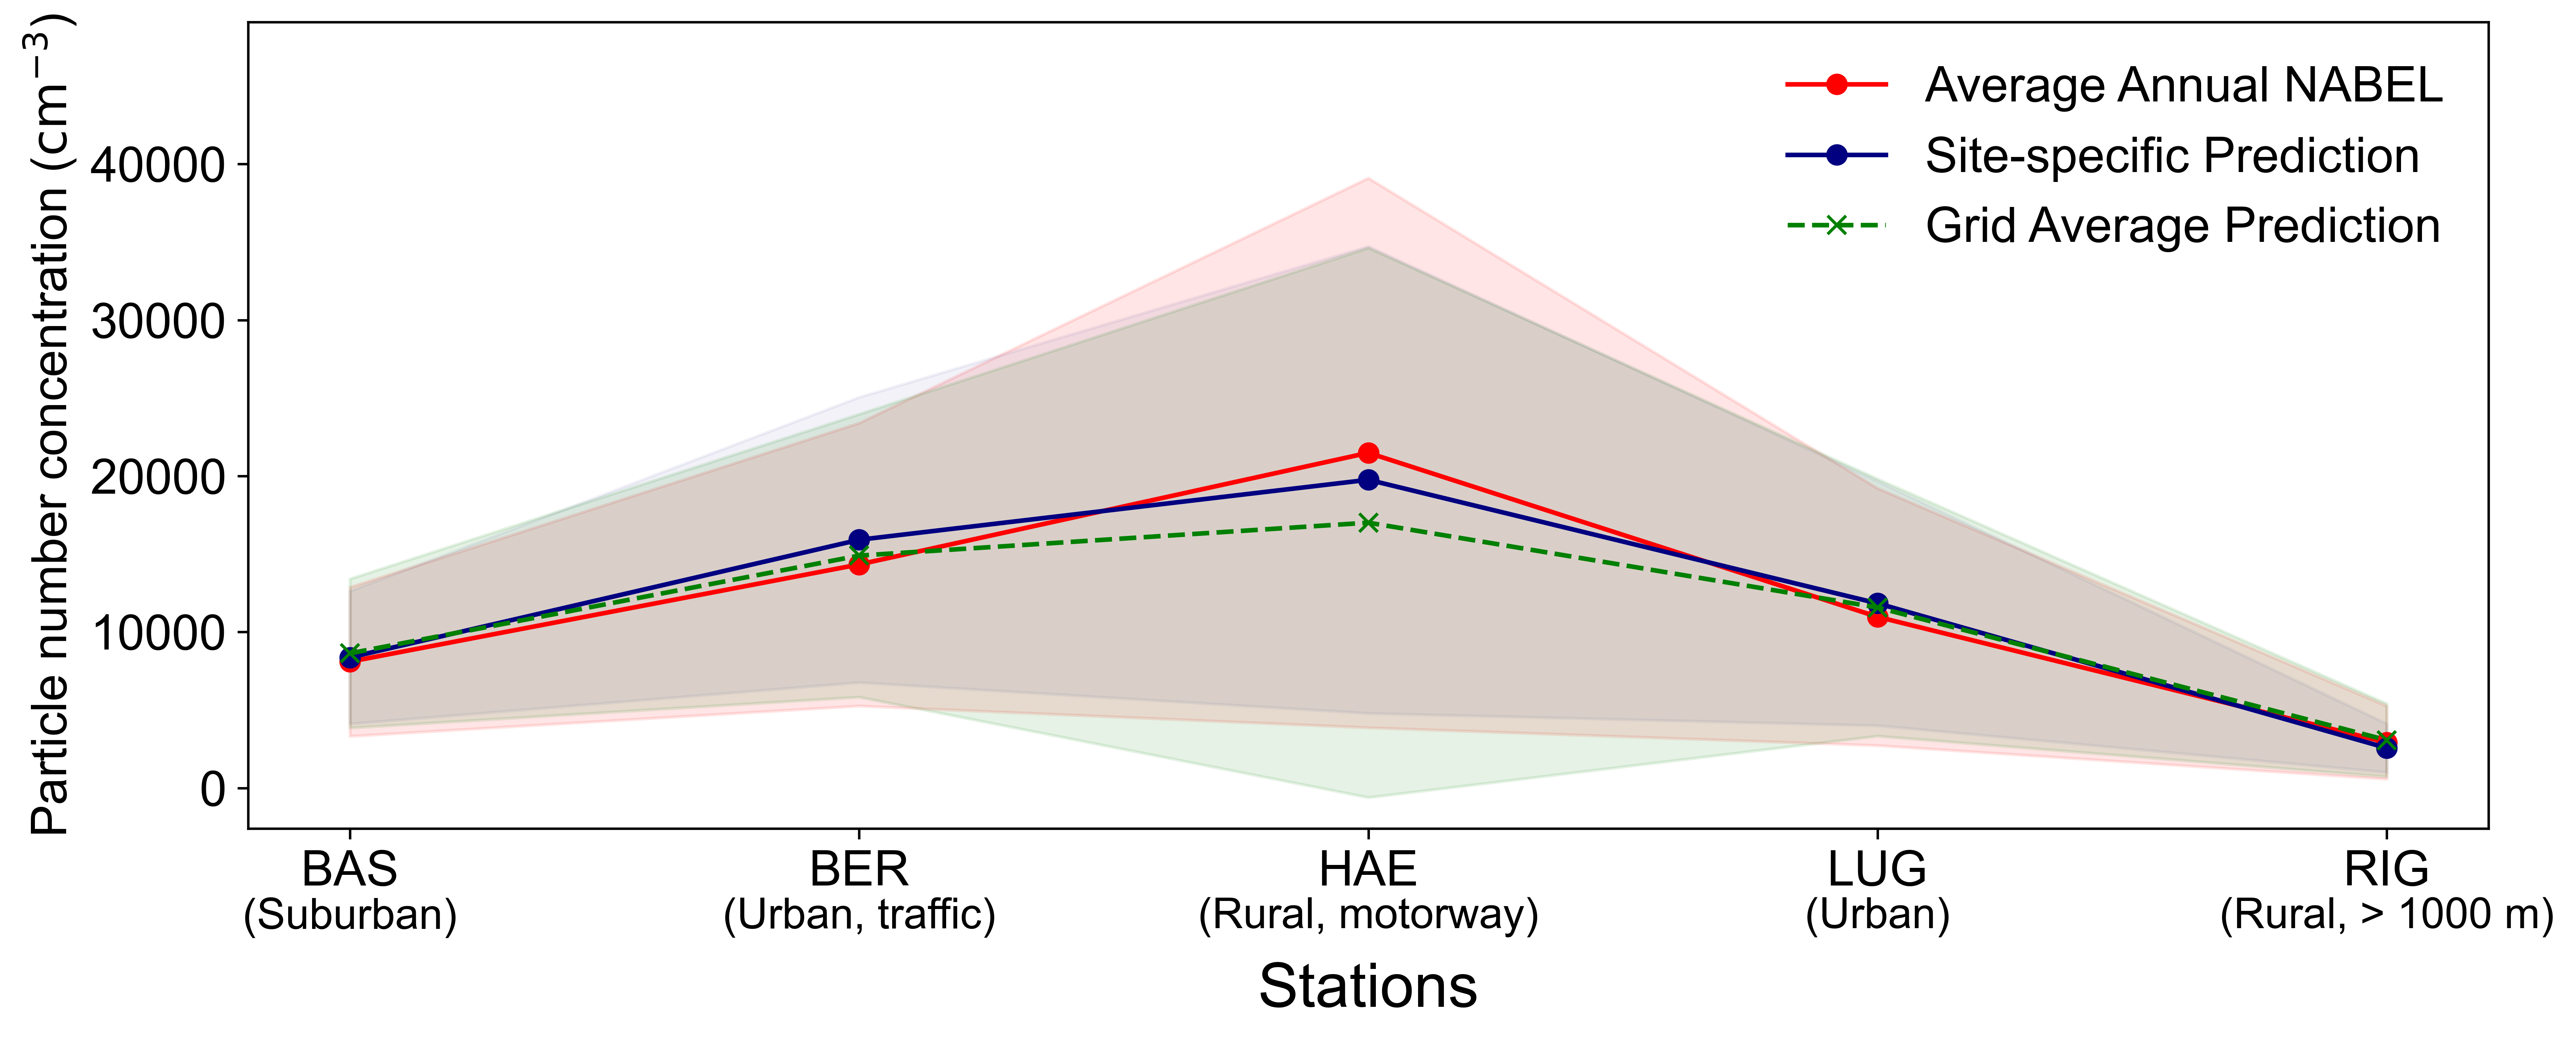

In [18]:
plt.figure(figsize=(12, 5), dpi=600)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16

#  plot CPC [1/cm3]
plt.plot(merged_df['stn'], merged_df['avg_cpc'], marker='o', label='Average Annual NABEL', color='red')
upper_bound_cpc = merged_df['avg_cpc'] + merged_df['std_cpc']
lower_bound_cpc = merged_df['avg_cpc'] - merged_df['std_cpc']
plt.fill_between(merged_df['stn'], lower_bound_cpc, upper_bound_cpc, color='red', alpha=0.1)

# plot pred PNC [1/cm3]
plt.plot(merged_df['stn'], merged_df['avg_pnc_pred'], marker='o', label='Site-specific Prediction', color='navy')
upper_bound_pnc = merged_df['avg_pnc_pred'] + merged_df['std_pnc_pred']
lower_bound_pnc = merged_df['avg_pnc_pred'] - merged_df['std_pnc_pred']
plt.fill_between(merged_df['stn'], lower_bound_pnc, upper_bound_pnc, color='navy', alpha=0.05)


colors = ['green']
color_idx = 0
max_grid = []
select_CPC = 'Stacking_'
for column in gisdata.columns:
    if select_CPC + 'avgConc' in column:
        # select the color
        current_color = colors[color_idx % len(colors)]
        color_idx += 1
        max_grid.append(merged_df[column])
        # plot avgConc lines
        plt.plot(merged_df['stn'], merged_df[column], marker='x', label='Grid Average Prediction', color=current_color,
                 linestyle='--')

        merged_df[column] = pd.to_numeric(merged_df[column], errors='coerce')
        merged_df['std_cpc'] = pd.to_numeric(merged_df['std_cpc'], errors='coerce')
        upper_bound = merged_df[column] + merged_df['std_cpc']
        lower_bound = merged_df[column] - merged_df['std_cpc']
        plt.fill_between(merged_df['stn'], lower_bound, upper_bound, color=current_color, alpha=0.1)
print(np.max(merged_df['avg_cpc']))
print(np.max(np.abs(merged_df['avg_cpc']-merged_df['avg_pnc_pred'])),
      np.min(np.abs(merged_df['avg_cpc']-merged_df['avg_pnc_pred'])))
print(np.max(np.abs(merged_df['avg_cpc']-np.array(max_grid).reshape(-1))),
      np.min(np.abs(merged_df['avg_cpc']-np.array(max_grid).reshape(-1))))
print(merged_df['avg_cpc'][2]-merged_df['avg_pnc_pred'][2])
print(merged_df['avg_cpc'][2]-np.array(max_grid).reshape(-1)[2])
y_min = min(min(lower_bound), min(lower_bound_cpc), min(lower_bound_pnc))-2000
y_max = max(max(upper_bound), max(upper_bound_cpc), max(upper_bound_pnc))+10000
plt.ylim(y_min, y_max)
plt.legend(frameon=False)
# add station info
second_line_labels = ['(Suburban)', '(Urban, traffic)', '(Rural, motorway)', '(Urban)', '(Rural, > 1000 m)']
for i, label in enumerate(second_line_labels):
    plt.text(i, -0.085, label, ha='center', va='top', transform=plt.gca().get_xaxis_transform(), fontsize = 14)
plt.xlabel("Stations", fontsize=20, labelpad=22)
plt.ylabel(r"Particle number concentration ($\mathrm{cm}^{-3}$)", fontsize=16)
plt.tight_layout()
# plt.grid()
plt.savefig('./figure/CPC_station_pred_compare.png', dpi=600, bbox_inches='tight')
plt.show()

In [18]:
# import pandas as pd
# import os
# import warnings
# warnings.filterwarnings('ignore')
# from scipy.io import loadmat

# gisdata = pd.read_csv('../../pncEstimator-main/data/station_gis.csv')
# pnc2020data = pd.read_csv('../../pncEstimator-main/data/NABEL/feature_eng/feature_data_2020.csv')
# pnc2020data = pnc2020data.drop(['Unnamed: 0'], axis=1)
# pnc2020data['Date/time'] = pd.to_datetime(pnc2020data['Date/time'], format='%Y-%m-%d %H:%M:%S')
# pncdata = pd.read_csv('../../pncEstimator-main/data/NABEL/pollutants/CPC.csv', sep=';', skiprows=6)
# pncdata['Date/time'] = pd.to_datetime(pncdata['Date/time'], format='%d.%m.%Y %H:%M')
# pncdata = pncdata[(pncdata['Date/time'] >='2020-01-01 01:00')&(pncdata['Date/time'] < '2021-01-01 01:00')]
# pncdata.reset_index(inplace=True)
# pncdata['index'] = range(8784)
# pncdata.columns = ['index', 'Date/time', 'BER', 'LUG', 'BAS', 'HAE', 'RIG']

# def gisdata_temp(gisdata, station_name):
#     temp = gisdata[(gisdata['stn'] == station_name)].iloc[:, 10:].T
#     temp.reset_index(inplace=True)
#     letter_count = sum(c.isalpha() for c in temp['index'][0].split('_')[2])
#     temp['temp'] = temp['index'].apply(lambda x: x.split('_')[2][letter_count:]).astype('int')
#     temp = temp.sort_values(by='temp')
#     temp.columns = ['index', station_name + '_Stacking', 'hourId']
#     temp = temp.drop(['index'], axis=1)
#     temp = temp.reset_index(drop=True)
#     return temp

# matpnc = os.listdir('../../pncEstimator-main/src/postProcessing/matdata/pncall3/')
# for data in matpnc:
#     if data.endswith('.mat'):
#         matdata = loadmat('../../pncEstimator-main/src/postProcessing/matdata/pncall3/' + data)
#         lonNew = matdata['lonNew']
#         latNew = matdata['latNew']
#         avgConc = matdata['avgConc']
#         col_name = '2020_avgConc_' + data.split('_')[2].split('.')[0]
#         gisdata, values = find_new_method2(col_name, gisdata, lonNew, latNew, avgConc)

# pred_pnc_list = [gisdata_temp(gisdata, 'BAS'), gisdata_temp(gisdata, 'BER'), gisdata_temp(gisdata, 'LUG'),
#                  gisdata_temp(gisdata, 'HAE'), gisdata_temp(gisdata, 'RIG')]
# for pred_pnc in pred_pnc_list:
#     pncdata = pd.merge(pncdata, pred_pnc, left_on='index', right_on='hourId', how='inner')
#     pncdata.drop(['hourId'], axis=1, inplace=True)

In [19]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# df = pncdata.set_index('Date/time')

# def date_cal(df, date_type):
#     def add_suffix(df, suffix):
#         return df.add_suffix(suffix)
#     if date_type == 'D':
#         mean = add_suffix(df.resample('D').mean(), '_mean')
#         std = add_suffix(df.resample('D').std(), '_std')
#     elif date_type == 'W':
#         mean = add_suffix(df.resample('W').mean(), '_mean')
#         std = add_suffix(df.resample('W').std(), '_std')
#     elif date_type == 'M':
#         mean = add_suffix(df.resample('M').mean(), '_mean')
#         std = add_suffix(df.resample('M').std(), '_std')
#     elif date_type == 'Q':
#         qmean = add_suffix(df.resample('Q').mean(), '_mean')
#         std = add_suffix(df.resample('Q').std(), '_std')

#     result = pd.concat([mean, std], axis=1)
#     return result

# result = date_cal(df, 'M')
# result.dropna(inplace=True)
# result.reset_index(inplace=True)
# result['Date/time'] = result['Date/time'].dt.date.apply(lambda x: x.strftime('%Y-%m'))

# data_to_plot = pd.DataFrame()

# # the color of the boxplot
# stations = ['BER', 'LUG', 'BAS', 'HAE', 'RIG']
# base_colors = sns.color_palette('Set3', n_colors=len(stations)*2)

# # change the data to fit the boxplot
# for station in stations:
#     for col_type in ['_mean', '_Stacking_mean']:
#         temp_df = result[['Date/time', f'{station}{col_type}']].copy()
#         temp_df.rename(columns={f'{station}{col_type}': 'Value'}, inplace=True)
#         temp_df['Type'] = 'Estimated PNC' if 'Stacking'in col_type else 'NABEL PNC'
#         temp_df['Station'] = station
#         data_to_plot = pd.concat([data_to_plot, temp_df])

# # plot the boxplot
# plt.figure(figsize=(10, 5), dpi=300)
# plt.rcParams['font.family'] = 'Arial'
# plt.rcParams['font.size'] = 16
# sns.boxplot(x='Date/time', y='Value', hue='Type', data=data_to_plot,
#             palette=base_colors)

# plt.xlabel("Date/Time", fontsize=20)
# plt.ylabel(r"PNC Value ($\# \cdot cm^{-3}$)", fontsize=20)
# plt.xticks(rotation=45)
# plt.legend()
# plt.tight_layout()
# plt.savefig('./figure/CPC_month_pred_compare.png', dpi=600)
# plt.show()

- SI

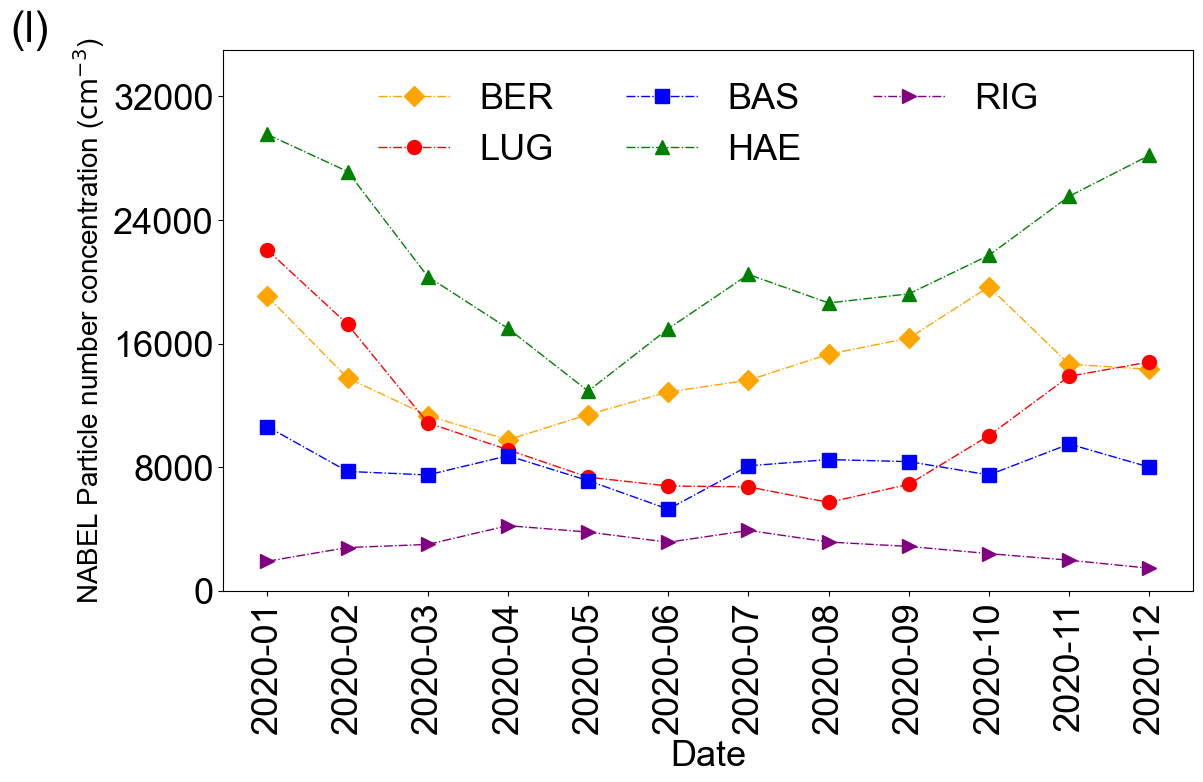

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 26

data = pd.read_csv('../../pncEstimator-main/data/NABEL/pollutants/CPC.csv', sep=';', skiprows=6)
data['Date/time'] = pd.to_datetime(data['Date/time'], format='%d.%m.%Y %H:%M')
data = data[(data['Date/time'] >= '2020-01-01') & (data['Date/time'] <= '2020-12-31')]
data['month'] = data['Date/time'].dt.date.apply(lambda x: x.strftime('%Y-%m'))
month_result = data.groupby('month').mean().reset_index()

plt.figure(figsize=(12, 8), dpi=100)
plt.plot(month_result['month'], month_result['Bern-Bollwerk'], label='BER',
         color='orange', linestyle='-.', linewidth=1, marker='D', markersize=10)
plt.plot(month_result['month'], month_result['Lausanne-Cesar-Roux'], label='LUG',
         color='red', linestyle='-.', linewidth=1, marker='o', markersize=10)
plt.plot(month_result['month'], month_result['Basel-Binningen'], label='BAS',
         color='blue', linestyle='-.', linewidth=1, marker='s', markersize=10)
plt.plot(month_result['month'], month_result['Harkingen-A1'], label='HAE',
         color='green', linestyle='-.', linewidth=1, marker='^', markersize=10)
plt.plot(month_result['month'], month_result['Rigi-Seebodenalp'], label='RIG',
         color='purple', linestyle='-.', linewidth=1, marker='>', markersize=10)

plt.ylim(0, 35000)
plt.xlabel('Date', fontsize=26)
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_locator(MaxNLocator(5))
plt.ylabel(r"NABEL Particle number concentration ($\mathrm{cm}^{-3}$)", fontsize=20)

# plt.ylabel(r"NABEL PNC ($\# \cdot cm^{-3}$)", fontsize=20)
plt.legend(loc='upper center', ncol=3, edgecolor='black', frameon=False)
plt.tight_layout()
plt.gca().title.set_text(f'(l)')
plt.gca().title.set_position([-0.2, 1.2])
plt.savefig('../SI_figure/S3/month/NABEL_PNC_month.png', dpi=600, bbox_inches='tight')
plt.show()

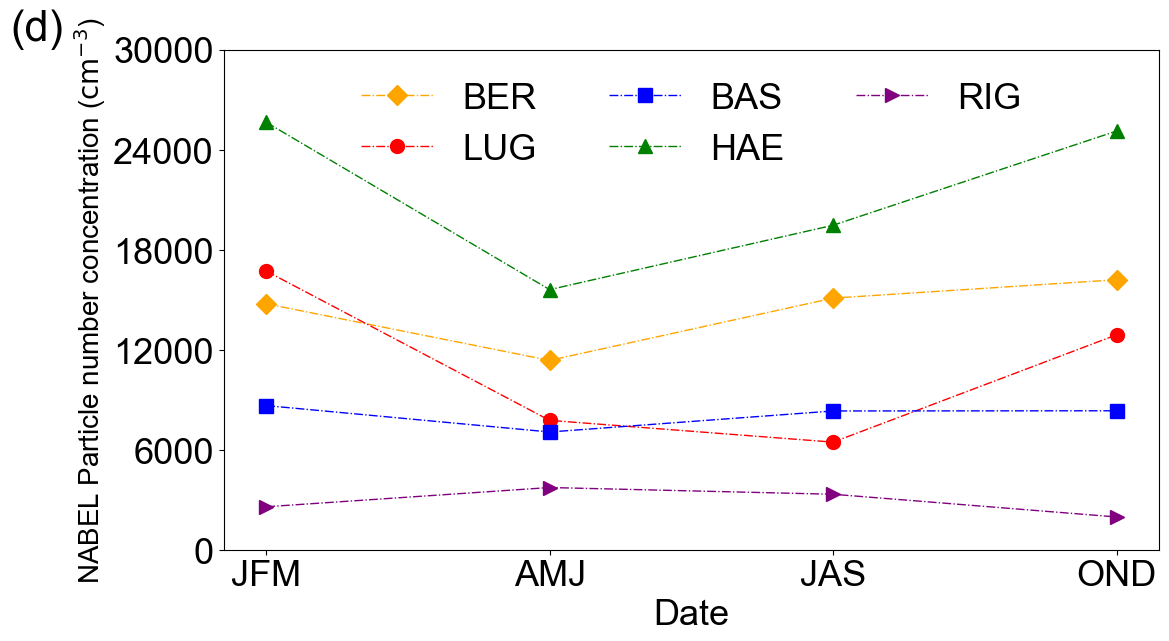

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 26

def month_to_season(month):
    if month in ['01', '02', '03']:
        return 'JFM'
    elif month in ['04', '05', '06']:
        return 'AMJ'
    elif month in ['07', '08', '09']:
        return 'JAS'
    else:
        return 'OND'


data = pd.read_csv('../../pncEstimator-main/data/NABEL/pollutants/CPC.csv', sep=';', skiprows=6)
data['Date/time'] = pd.to_datetime(data['Date/time'], format='%d.%m.%Y %H:%M')
data = data[(data['Date/time'] >= '2020-01-01') & (data['Date/time'] <= '2020-12-31')]
data['season'] = data['Date/time'].dt.strftime('%m').apply(month_to_season)
season_result = data.groupby('season').mean().reset_index()
season_order = ['JFM', 'AMJ', 'JAS', 'OND']
season_result['season'] = pd.Categorical(season_result['season'], categories=season_order, ordered=True)
season_result = season_result.sort_values('season').reset_index(drop=True)

plt.figure(figsize=(12, 7), dpi=100)
plt.plot(season_result['season'], season_result['Bern-Bollwerk'], label='BER',
         color='orange', linestyle='-.', linewidth=1, marker='D', markersize=10)
plt.plot(season_result['season'], season_result['Lausanne-Cesar-Roux'], label='LUG',
         color='red', linestyle='-.', linewidth=1, marker='o', markersize=10)
plt.plot(season_result['season'], season_result['Basel-Binningen'], label='BAS',
         color='blue', linestyle='-.', linewidth=1, marker='s', markersize=10)
plt.plot(season_result['season'], season_result['Harkingen-A1'], label='HAE',
         color='green', linestyle='-.', linewidth=1, marker='^', markersize=10)
plt.plot(season_result['season'], season_result['Rigi-Seebodenalp'], label='RIG',
         color='purple', linestyle='-.', linewidth=1, marker='>', markersize=10)
# plt.xticks(rotation=45)
plt.ylim(0, 30000)
plt.xlabel('Date', fontsize=26)
plt.gca().yaxis.set_major_locator(MaxNLocator(5))
plt.ylabel(r"NABEL Particle number concentration ($\mathrm{cm}^{-3}$)", fontsize=20)
plt.legend(loc='upper center', ncol=3, edgecolor='black', frameon=False)
plt.gca().title.set_text(f'(d)')
plt.gca().title.set_position([-0.2, 1.2])
plt.tight_layout()
plt.savefig('../SI_figure/S3/season/NABEL_PNC_season.png', dpi=600, bbox_inches='tight')
plt.show()

In [6]:
from scipy.io import loadmat
import numpy as np

mat0 = loadmat('../../pncEstimator-main/src/postProcessing/matdata/PNCtest/0102/4part/2020PNC_avgConc_Stacking_part0.mat')
mat1 = loadmat('../../pncEstimator-main/src/postProcessing/matdata/PNCtest/0102/4part/2020PNC_avgConc_Stacking_part1.mat')
mat2 = loadmat('../../pncEstimator-main/src/postProcessing/matdata/PNCtest/0102/4part/2020PNC_avgConc_Stacking_part2.mat')
mat3 = loadmat('../../pncEstimator-main/src/postProcessing/matdata/PNCtest/0102/4part/2020PNC_avgConc_Stacking_part3.mat')

lonNew = mat0['lonNew']
latNew = mat0['latNew']
avgConc0 = mat0['avgConc']
avgConc1 = mat1['avgConc']
avgConc2 = mat2['avgConc']
avgConc3 = mat3['avgConc']
diff1 = avgConc1 - avgConc0
diff2 = avgConc2 - avgConc1
diff3 = avgConc3 - avgConc2
diff1_0 = np.where(diff1>0, 1, 0)
diff2_0 = np.where(diff2>0, 1, 0)
diff3_0 = np.where(diff3>0, 1, 0)
diff1_1 = np.where(diff1<0, 1, 0)
diff2_1 = np.where(diff2<0, 1, 0)
diff3_1 = np.where(diff3<0, 1, 0)
print(np.sum(diff1_0)/112041, np.sum(diff1_1)/112041)
print(np.max(diff1), np.min(diff1))
print(np.sum(diff2_0)/112041, np.sum(diff2_1)/112041)
print(np.max(diff2), np.min(diff2))
print(np.sum(diff3_0)/112041, np.sum(diff3_1)/112041)
print(np.max(diff3), np.min(diff3))

0.682883944270401 0.317116055729599
1133.0244724359827 -15571.26550736339
0.8527414071634491 0.1472585928365509
4745.8428131182845 -3234.217541348684
0.14572344052623593 0.854276559473764
18418.3836228104 -1908.1260132993402


In [4]:
road_mat = loadmat('../../pncEstimator-main/data/roadData/trafficVol.mat')
road_data = road_mat['trafficVol']
road_data_0 = np.where(road_data>0, 1, 0)
print(np.sum(road_data_0)/(road_data.shape[0]*road_data.shape[1]))

0.24683007154882156


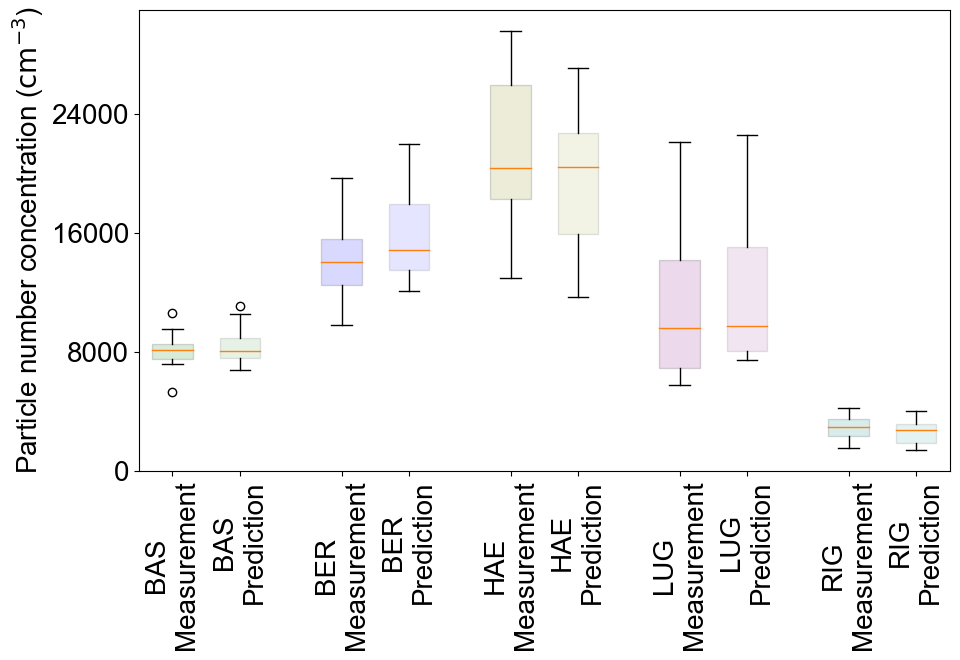

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import ScalarFormatter, MaxNLocator
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 20

stations = data_df['station'].unique()
colors = ['green', 'blue', 'olive', 'purple', 'teal']
plt.figure(figsize=(10, 7), dpi=100)

positions = []
for idx, station in enumerate(stations):
    station_data = data_df[data_df['station'] == station]
    box_data = [station_data['CPC [1/cm3]_mean'], station_data['stack_pred_mean']]
    pos = [idx*2.5, idx*2.5 + 1]
    positions.extend(pos)
    box = plt.boxplot(box_data, positions=pos, patch_artist=True, widths=0.6)

    for patch, color, alpha in zip(box['boxes'], [colors[idx % len(colors)]]*2, [0.15, 0.1]):
        patch.set_facecolor(color)
        patch.set_alpha(alpha)

labels = [f'{station}\nMeasurement' if i%2 == 0 else f'{station}\nPrediction' for station in stations for i in range(2)]
plt.xticks([pos for pos in positions], labels, rotation=90)
plt.ylabel(r"Particle number concentration ($\mathrm{cm}^{-3}$)")
plt.gca().yaxis.set_major_locator(MaxNLocator(4))
plt.tight_layout()
plt.savefig('../SI_figure/S1/stack_CPCvsPNC_boxplot.png', dpi=600, bbox_inches='tight')
plt.show()